### Get Required Libraries

In [3]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import AveragePooling2D, GlobalAveragePooling2D
from tensorflow.keras.layers import Conv2D, Input, ZeroPadding2D, BatchNormalization, Activation, MaxPooling2D, Flatten, Dense
from tensorflow.keras.layers import Dropout, Flatten
from tensorflow.keras.models import Model, load_model, save_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import tensorflow.keras as keras
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import random
import copyfile
import cv2

### Splitting Directories In Training and Testing

In [4]:
import shutil

In [16]:
with_mask_dir = 'C:/Users/harsh.HARSHIKALA/Downloads/data/with_mask'
without_mask_dir = 'C:/Users/harsh.HARSHIKALA/Downloads/data/without_mask'
output_dir = 'D:/MaskDetectionProject/dataset'

# Create train and test directories
for split in ['train', 'test']:
    for category in ['with_mask', 'without_mask']:
        os.makedirs(os.path.join(output_dir, split, category), exist_ok=True)

# Split function
def split_images(source_dir, category, train_ratio=0.8):
    images = os.listdir(source_dir)
    random.seed(42)  # Set a seed for reproducibility
    random.shuffle(images)
    train_size = int(len(images) * train_ratio)
    train_images = images[:train_size]
    test_images = images[train_size:]

    # Copy to train and test directories
    for img in train_images:
        shutil.copy(os.path.join(source_dir, img), os.path.join(output_dir, 'train', category, img))
    for img in test_images:
        shutil.copy(os.path.join(source_dir, img), os.path.join(output_dir, 'test', category, img))

# Split the images
split_images(with_mask_dir, 'with_mask')
split_images(without_mask_dir, 'without_mask')

### Read Image Files

In [17]:
train_data = ('D:/MaskDetectionProject/dataset/train')
test_data = ('D:/MaskDetectionProject/dataset/test')

### Get Image Classes

In [18]:
batch_size = 32

In [19]:
trainGen = ImageDataGenerator(rescale = 1./255, shear_range=0.2, horizontal_flip= True, zoom_range = 0.2)

testGen = ImageDataGenerator(rescale = 1./255)

final_train = trainGen.flow_from_directory(train_data, target_size=(224,224), classes=['with_mask', 'without_mask'], class_mode = 'categorical', batch_size = batch_size, shuffle = True)

final_test = testGen.flow_from_directory(test_data, target_size=(224,224), class_mode = 'categorical', batch_size = batch_size)

Found 6042 images belonging to 2 classes.
Found 1511 images belonging to 2 classes.


### Get MobileNetV2 Model and Weights

In [20]:
pretrained_model = MobileNetV2(
    alpha = 1.0,
    input_shape = (224, 224, 3),
    include_top = False,
    weights = 'imagenet',
)

pretrained_model.trainable = False

### Define Model Architecture

In [21]:
model = Sequential()
model.add(pretrained_model)
model.add(GlobalAveragePooling2D())
model.add(Dropout(0.2))

model.add(Dense(2, activation = 'softmax'))

model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

In [22]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224 (Functional)    │ (None, 7, 7, 1280)          │       2,257,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_1           │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 1280)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 2)                   │           2,562 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,260,546 (8.62 MB)

 Trainable params: 2,562 (10.01 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

 ### Fit Model
 #### Step 1: Train the model for 5 epochs on the training set (final_train)
 #### Do NOT use validation_data to avoid test set leakage

In [23]:
history = model.fit(
    final_train,                    # Training data generator
    steps_per_epoch=len(final_train),  # 6042 / 32 ≈ 189 steps
    epochs=5                        # Start with 5 epochs
)

Epoch 1/5
189/189 ━━━━━━━━━━━━━━━━━━━━ 225s 1s/step - accuracy: 0.4945 - loss: 0.9490
Epoch 2/5
189/189 ━━━━━━━━━━━━━━━━━━━━ 168s 889ms/step - accuracy: 0.8990 - loss: 0.2957
Epoch 3/5
189/189 ━━━━━━━━━━━━━━━━━━━━ 167s 882ms/step - accuracy: 0.9501 - loss: 0.1696
Epoch 4/5
189/189 ━━━━━━━━━━━━━━━━━━━━ 166s 877ms/step - accuracy: 0.9651 - loss: 0.1216
Epoch 5/5
189/189 ━━━━━━━━━━━━━━━━━━━━ 171s 906ms/step - accuracy: 0.9702 - loss: 0.1023


##### Note: len(final_train) is the number of batches (189), automatically calculated by flow_from_directory

#### Step 2: Plot training accuracy and loss to assess learning progress

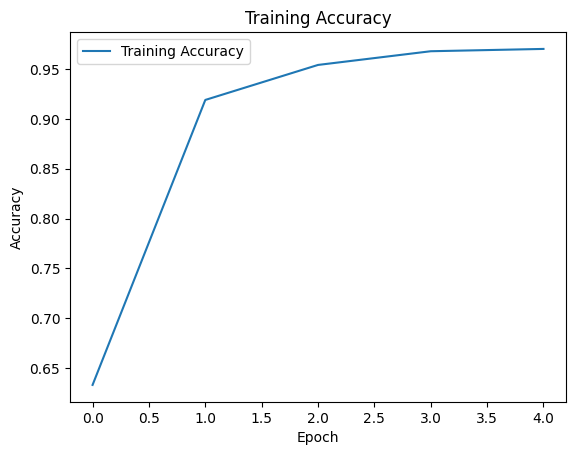

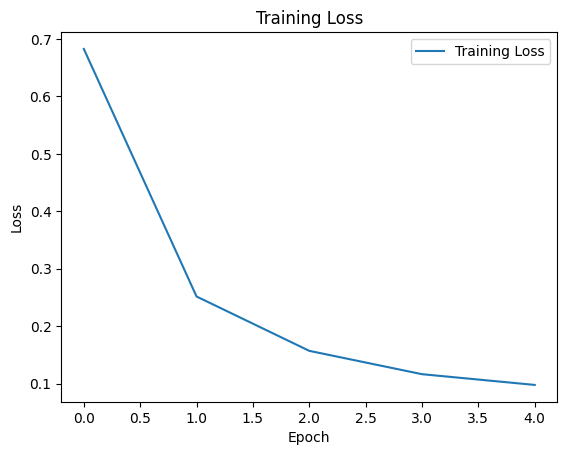

In [24]:
# Plot training accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.title('Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot training loss
plt.plot(history.history['loss'], label='Training Loss')
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

#### Step 3: Evaluate the model on the test set after 5 epochs
#### 1511 test images, 1511 / 32 ≈ 47 steps

In [25]:
test_loss, test_accuracy = model.evaluate(final_test, steps=len(final_test))
print(f"After 5 epochs - Test Loss: {test_loss}, Test Accuracy: {test_accuracy}")

48/48 ━━━━━━━━━━━━━━━━━━━━ 50s 954ms/step - accuracy: 0.9656 - loss: 0.1022
After 5 epochs - Test Loss: 0.0998423770070076, Test Accuracy: 0.9662474989891052


### Save the model in the project folder

In [27]:
model.save('mask_detection_model.keras')

### Load the Model

In [28]:
saved_model = load_model('mask_detection_model.keras', compile=False)

### Defining Prediction Function

In [32]:
from tensorflow.keras.preprocessing import image

In [41]:
def predict_mask(path):
    img_pred = image.load_img(path, target_size=(224, 224))
    img_pred = image.img_to_array(img_pred)
  
    plt.imshow(img_pred.astype(np.uint8))  # No need for cv2.cvtColor since image.load_img loads in RGB
    plt.show()
    
    # Add batch dimension and normalize
    img = np.expand_dims(img_pred, axis=0)
    img = img / 255.0  # Normalize to match training preprocessing
    
    # Predict probabilities
    probabilities = saved_model.predict(img)
    predicted_class = np.argmax(probabilities, axis=1)[0] 
    
    # Print probabilities
    max_prob = np.max(probabilities)
    print("Prediction Probabilities:", probabilities)
    print("Predicted Class:", predicted_class)
    
    if max_prob < 0.7:  # Flag low-confidence predictions
        prediction = "Uncertain (Confidence: {:.2f}%)".format(max_prob * 100)
    else:
        if predicted_class != 0:  
            prediction = "NO MASK"
        else:
            prediction = "MASK"
    
    print("Prediction:", prediction)
    
    return prediction

### Call Function and Predict

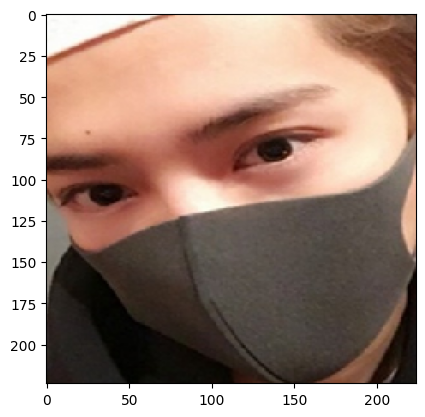

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step
Prediction Probabilities: [[0.9955036  0.00449637]]
Predicted Class: 0
Prediction: MASK


In [42]:
prediction = predict_mask('D:/MaskDetectionProject/dataset/test/with_mask/with_mask_272.jpg')

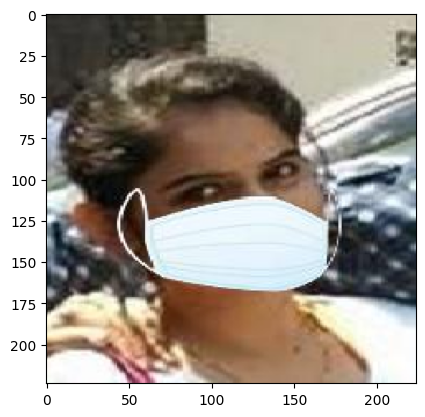

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
Prediction Probabilities: [[0.99638295 0.00361705]]
Predicted Class: 0
Prediction: MASK


In [43]:
prediction = predict_mask('D:/MaskDetectionProject/dataset/test/with_mask/with_mask_959.jpg')

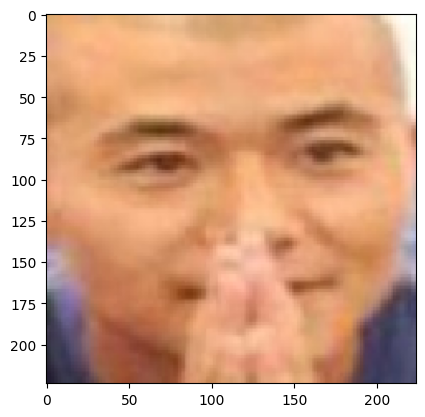

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step
Prediction Probabilities: [[0.00519007 0.99480987]]
Predicted Class: 1
Prediction: NO MASK


In [44]:
prediction = predict_mask('D:/MaskDetectionProject/dataset/test/without_mask/without_mask_130.jpg')

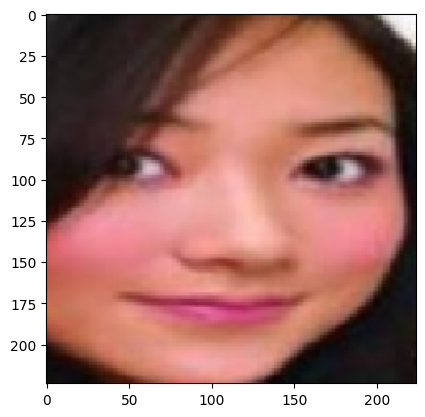

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step
Prediction Probabilities: [[0.13037434 0.8696256 ]]
Predicted Class: 1
Prediction: NO MASK


In [45]:
prediction = predict_mask('D:/MaskDetectionProject/dataset/test/without_mask/without_mask_346.jpg')

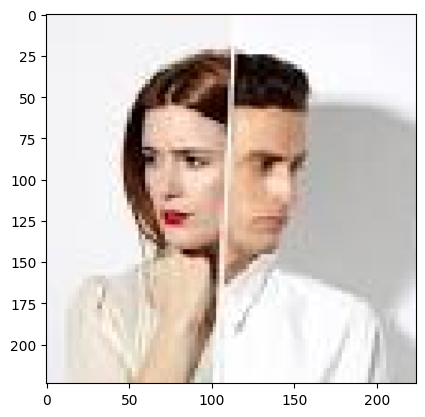

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step
Prediction Probabilities: [[0.68835443 0.31164557]]
Predicted Class: 0
Prediction: Uncertain (Confidence: 68.84%)


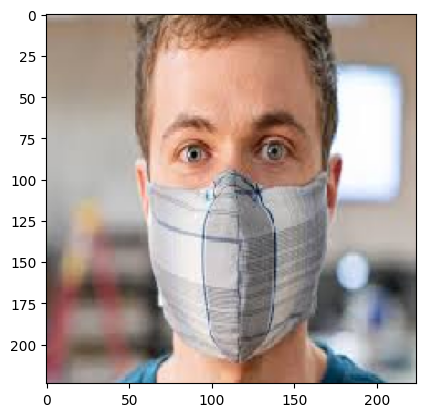

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step
Prediction Probabilities: [[0.9924454  0.00755456]]
Predicted Class: 0
Prediction: MASK


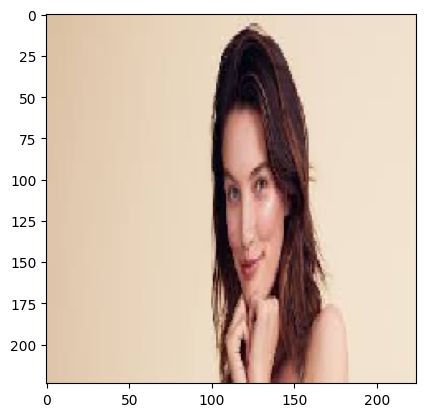

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step
Prediction Probabilities: [[0.15598352 0.8440165 ]]
Predicted Class: 1
Prediction: NO MASK


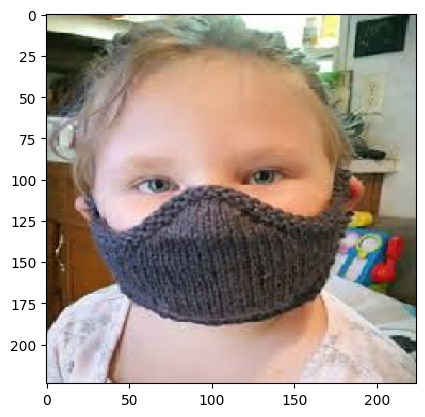

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
Prediction Probabilities: [[0.98983765 0.01016235]]
Predicted Class: 0
Prediction: MASK


In [46]:
prediction = predict_mask('D:/MaskDetectionProject/dataset/test/without_mask/without_mask_660.jpg')
prediction = predict_mask('D:/MaskDetectionProject/dataset/test/with_mask/with_mask_820.jpg')
prediction = predict_mask('D:/MaskDetectionProject/dataset/test/without_mask/without_mask_1010.jpg')
prediction = predict_mask('D:/MaskDetectionProject/dataset/test/with_mask/with_mask_768.jpg')